In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
# read list of all png images in the ./labels folder
img_list = glob.glob('./labels/*.png')

# read labels csv file into a pandas dataframe (df)
csv_file = glob.glob('./labels/*.csv')
labels_df = pd.read_csv(csv_file[0])

# see how the df looks
labels_df.head()

,filename,angle
0,Angle_-70_1.png,-69.921771
1,Angle_-70_2.png,-69.921771
2,Angle_-70_3.png,-69.921771
3,Angle_-70_4.png,-69.921771
4,Angle_-70_5.png,-69.921771


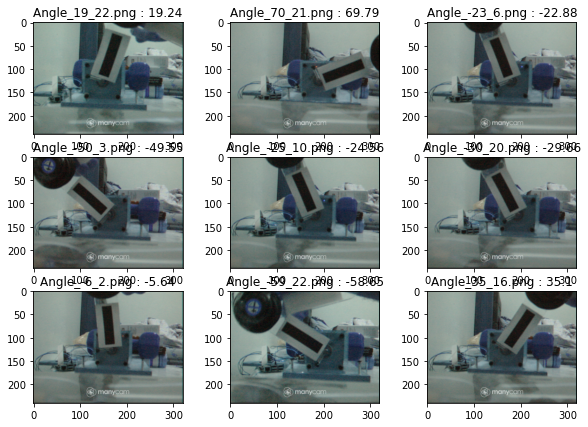

In [3]:
# ranfomly select 9 rows and plot to explor the dataset
small_df = labels_df.sample(n=9)

fig = plt.figure(figsize=(10, 7))
for k in range(9):
    fig.add_subplot(3, 3, k + 1)
    plt.imshow(cv2.imread('./labels/' + small_df.iloc[k]['filename'], cv2.IMREAD_COLOR))
    plt.title(small_df.iloc[k]['filename'] + ' : ' + str(round(small_df.iloc[k]['angle'],2)))


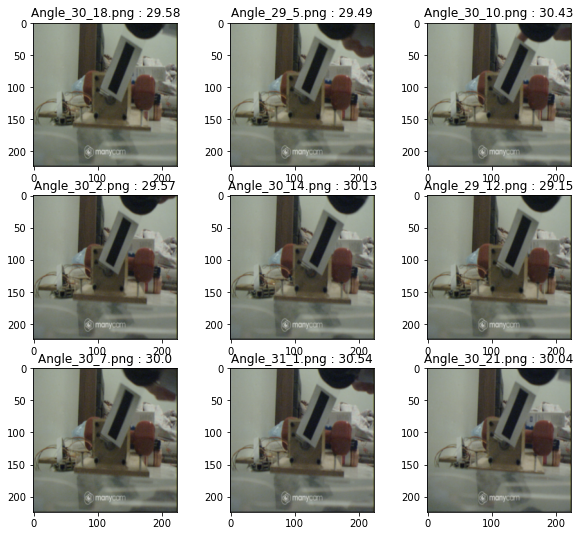

In [4]:
# select some of the images with similar angles to check if data is correctly labeled
small_df = labels_df[(labels_df['angle'] < 31) & (labels_df['angle']>29)].sample(n=9)

fig = plt.figure(figsize=(10, 9))
for k in range(9):
    fig.add_subplot(3, 3, k + 1)
    im = load_img('./labels/' + small_df.iloc[k]['filename'],
                  target_size=(224, 224),
                  interpolation='bilinear')
#     im = cv2.imread('./labels/' + small_df.iloc[k]['filename'])
    plt.imshow(im)
    plt.title(small_df.iloc[k]['filename'] + ' : ' + str(round(small_df.iloc[k]['angle'],2)))

## Using Transfer Learning for Pendubot angle estimation
VGG is a well-known Deep Concolutional Neural Network trained on millions of labeled images and won the 2014 image classification competition.
The winners piblished the trained weights and allowed scientific community to use it for their own tasks. The rationale is that the trained model has learned how to extract useful features form any type of images. So others can use the features for their own tasks. This is called Transfer Learning. To reuse the trained DNN weights for one task, for another taks that we don't have enough labeled data. We just fine tune the network weight for our target task.
In this work, we use VGG network, remove the top classifying layer, and replace it with our own regression layer (because we want to estimate angle, and we don't want to do classification).

#### Based on
- [vgg regression](https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/)
- [Transfer learning for images](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)

### well-know networks for transfer learning
- VGG: color input images to be rescaled to the size of 224×224 squares.
- InseptionV3: The model expects color images to have the square shape 299×299
- ResNet50: The model expects color images to have the square shape 224×224.

In [6]:
# define the path to the base output directory
BASE_OUTPUT = "output"

config = {'INIT_LR':  1e-4, 'NUM_EPOCHS': 20,  'BATCH_SIZE': 32,
          'test_files_list': 'testset.txt',
          'labels_dir' : './labels',
          'MODEL_PATH':  os.path.sep.join([BASE_OUTPUT, "detector.h5"])}

In [12]:
data, targets, filenames = [], [], []
for k, row in labels_df.iterrows():
    image_path = os.path.join(config['labels_dir'], row['filename'])
    im = load_img(image_path, target_size=(224, 224))
    im = img_to_array(im)
    # update our list of data, targets, and filenames
    data.append(im)
    targets.append(0.5 + row['angle'] / 180)  # target should be in [0,1]
    filenames.append(row['filename'])

print('[INFO] targets range: ', np.min(targets), np.max(targets))
# convert the data and targets to NumPy arrays, scaling the input pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 80% of the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.20, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
with open(config['test_files_list'], "w") as f:
    f.write("\n".join(testFilenames))

[INFO] targets range:  0.0053642654855606264 0.9997465213085514
[INFO] saving testing filenames...


In [13]:
# load model and specify a new input shape for images
# new_input = Input(shape=(224, 224, 3))
# model = VGG16(include_top=False, input_tensor=new_input, pooling='max')  # removes the classifier part
# model = VGG16(include_top=False, input_tensor=new_input)  # removes the classifier part

# model = VGG16()
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output) # remove last two layest (classifier feedforward )
# add weights=None to randomly initialize weights
# images = ...
# prepared_images = preprocess_input(images)

vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten =  flatten = Flatten()(vgg.output)
# construct a fully-connected layer header to output the predicted bounding box coordinates
pendu_angle = Dense(128, activation="relu")(flatten)
pendu_angle = Dense(64, activation="relu")(pendu_angle)
pendu_angle = Dense(32, activation="relu")(pendu_angle)
pendu_angle = Dense(1, activation="sigmoid")(pendu_angle)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=pendu_angle)

In [14]:
# FINE TUNING
# initialize the optimizer, compile the model, and show the model summary
opt = Adam(lr=config['INIT_LR'])
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), 
              batch_size=config['BATCH_SIZE'], epochs=config['NUM_EPOCHS'], verbose=1)


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

[INFO] saving object detector model...


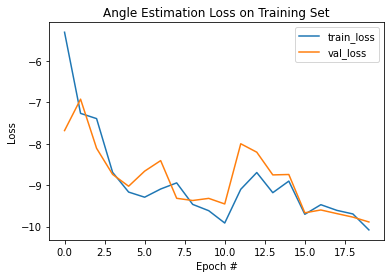

In [18]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config['MODEL_PATH'], save_format="h5")

# plot the model training history
N = config['NUM_EPOCHS']
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), np.log(H.history["loss"]), label="train_loss")
plt.plot(np.arange(0, N), np.log(H.history["val_loss"]), label="val_loss")
plt.title("Angle Estimation Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()
# plt.savefig(config.PLOT_PATH)

[INFO] loading object detector...


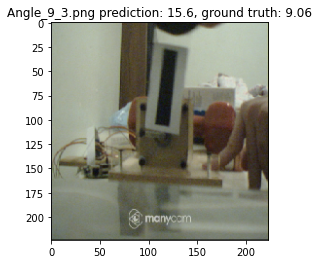

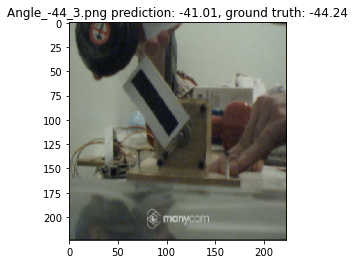

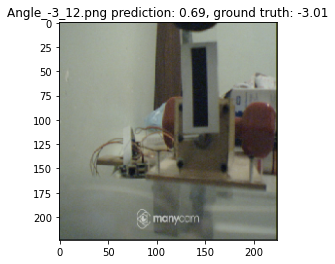

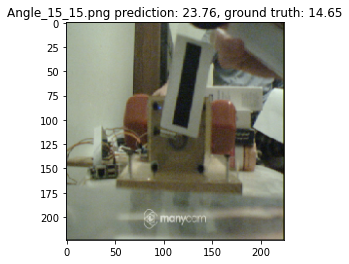

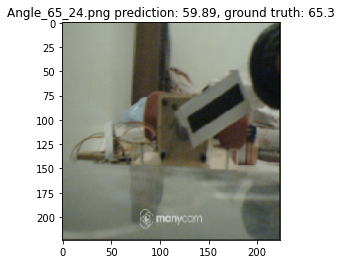

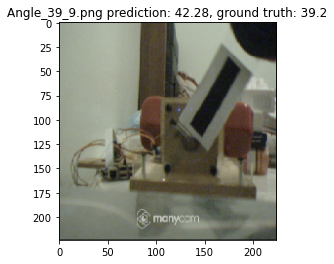

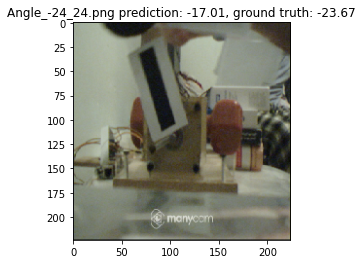

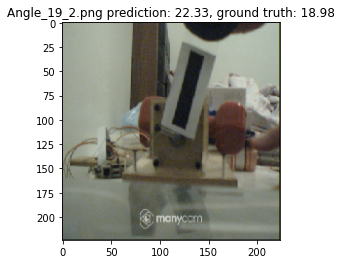

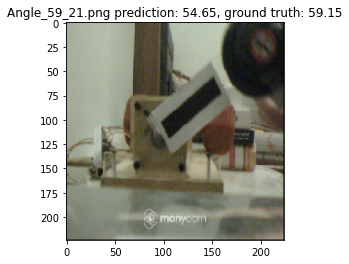

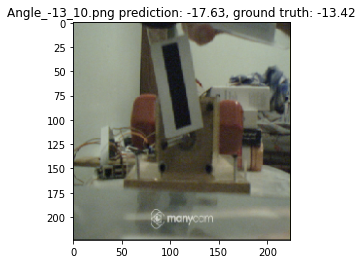

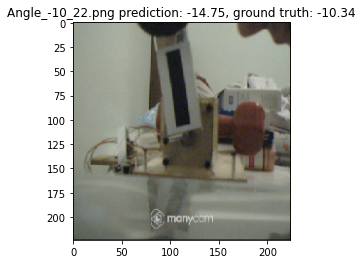

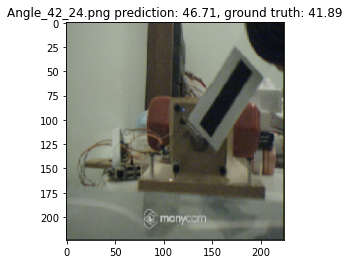

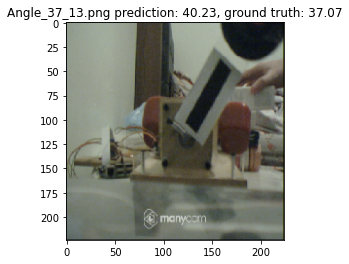

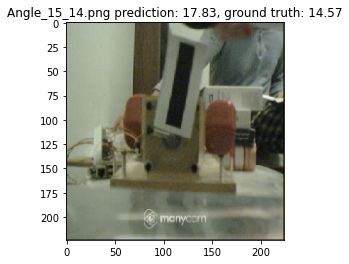

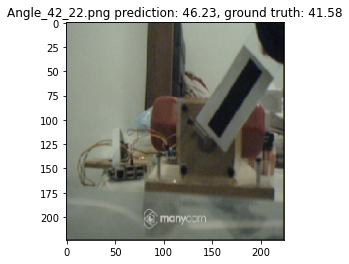

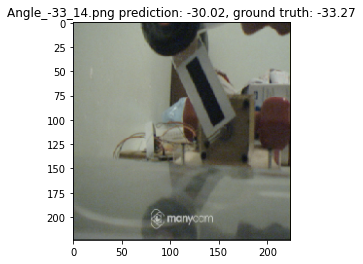

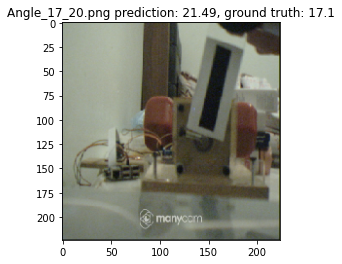

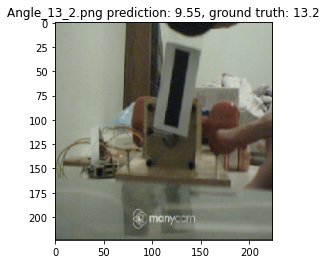

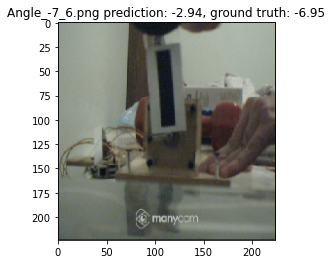

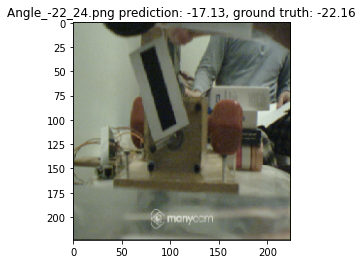

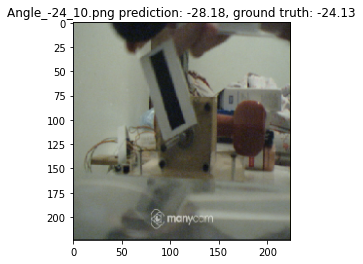

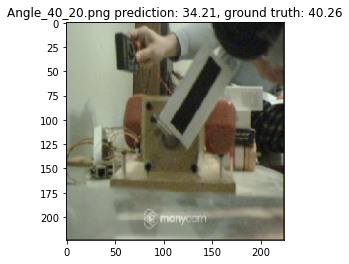

In [17]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(config['MODEL_PATH'])
filenames = open(config['test_files_list']).read().strip().split("\n")
labels = []
preds = []
errs = []
for f in filenames:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    imagePath = os.path.join(config['labels_dir'], f)
    image = load_img(imagePath, target_size=(224, 224))
    image0 = img_to_array(image) / 255.0
    image = np.expand_dims(image0, axis=0)
    prediction = 180 * (model.predict(image)[0][0] - 0.5)
    true_label = labels_df[labels_df['filename'] == f].iloc[0]['angle']
#     print(f, f"prediction: {round(prediction, 2)}, ground truth: {round(true_label, 2)}")
    if abs(prediction - true_label) > 3:
        plt.imshow(image0)
        plt.title(f + f" prediction: {round(prediction, 2)}, ground truth: {round(true_label, 2)}")
        plt.show()
    errs.append(prediction - true_label)
    preds.append(prediction)
    labels.append(true_label)


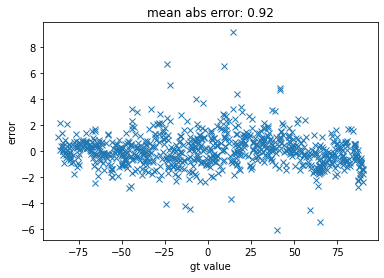

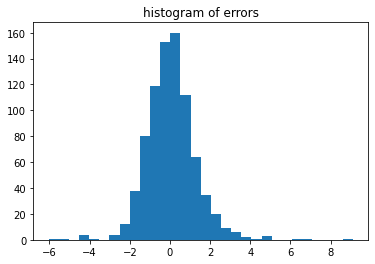

In [20]:
plt.plot(labels, errs, 'x')
plt.ylabel('error')
plt.xlabel('gt value')
plt.title('mean abs error: ' + str(round(np.mean(np.abs(errs)),2)))
plt.show()
plt.figure()
plt.hist(errs, 30)
plt.title('histogram of errors')
plt.show()

In [ ]:
# test to see how vgg's preprocess_input function changes the image. We may end up not using it
image = img_to_array(im)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image) # makes it float -128 to 128
plt.imshow(1 + image.squeeze()/np.max(image) )